In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TextDataset, DataCollatorForLanguageModeling, TrainingArguments, Trainer

# 1. 데이터 생성
pi = np.pi
x = np.linspace(-pi, pi, 1000)
y = np.sin(x)

# 데이터를 텍스트로 변환
data_str = '\n'.join([f"{xi:.5f} {yi:.5f}" for xi, yi in zip(x, y)])
with open('sin_data.txt', 'w') as f:
    f.write(data_str)

# 2. 데이터 준비
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
tokenizer.pad_token = tokenizer.eos_token

train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path="sin_data.txt",
    block_size=128
)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# 3. 모델 및 토크나이저 정의
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')

# 4. 학습
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=32,
    logging_steps=10,
    save_steps=10,
    save_total_limit=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
)

trainer.train()


/env/lib/python3.8/site-packages/transformers/data/datasets/language_modeling.py:54: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jesnk. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=9, training_loss=1.9549831814236112, metrics={'train_runtime': 12.2889, 'train_samples_per_second': 0.732, 'total_flos': 65401006325760.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 1659564032, 'init_mem_gpu_alloc_delta': 1444470784, 'init_mem_cpu_peaked_delta': 1445904384, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 23392256, 'train_mem_gpu_alloc_delta': 4257911296, 'train_mem_cpu_peaked_delta': 0, 'train_mem_gpu_peaked_delta': 17800595456})

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

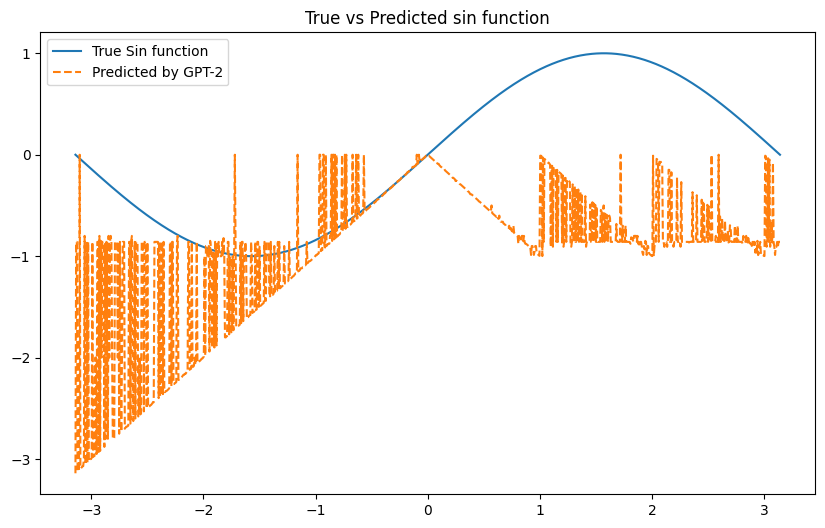

In [6]:
# ... [이전 코드는 생략] ...
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 5. 학습 결과
model.eval()
predicted_ys = []

for xi in x:
    prompt = f"{xi:.5f}"
    generated = tokenizer.encode(prompt, return_tensors="pt").to(device)
    sample_outputs = model.generate(generated, max_length=10, temperature=1.0, num_return_sequences=1)
    predicted_text = tokenizer.decode(sample_outputs[0], skip_special_tokens=True)
    
    # 텍스트를 숫자로 변환하는 함수
    try:
        _, predicted_y = predicted_text.split()
        predicted_ys.append(float(predicted_y))
    except ValueError:  # 숫자 변환 오류 처리
        predicted_ys.append(0)  # 잘못된 예측값은 0으로 처리 (적절한 처리 방법을 선택해야 함)

# 6. 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(x, y, label='True Sin function')
plt.plot(x, predicted_ys, label='Predicted by GPT-2', linestyle='dashed')
plt.legend()
plt.title('True vs Predicted sin function')
plt.show()


# Refactoring to handling Numerical data

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, TrainingArguments, Trainer

# 1. 데이터 생성
pi = np.pi
x = np.linspace(-pi, pi, 1000)
y = np.sin(x)

# Define a custom dataset for the sin function values
class SinDataset(Dataset):
    def __init__(self, x, y, tokenizer, block_size=128):
        self.x = x
        self.y = y
        self.tokenizer = tokenizer
        self.block_size = block_size
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        xi = self.x[idx]
        yi = self.y[idx]
        tokenized_input = self.tokenizer(f"{xi:.5f}", return_tensors="pt")
        tokenized_output = self.tokenizer(f"{yi:.5f}", return_tensors="pt")
        return tokenized_input.input_ids.squeeze(), tokenized_output.input_ids.squeeze()

# 2. 데이터 준비
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
tokenizer.pad_token = tokenizer.eos_token

train_dataset = SinDataset(x, y, tokenizer)
data_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 3. 모델 및 토크나이저 정의
model = GPT2LMHeadModel.from_pretrained('gpt2-medium')

# 4. 학습
training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    num_train_epochs=60,
    per_device_train_batch_size=32,
    logging_steps=10,
    save_steps=10,
    save_total_limit=2,
)

def pad_sequences(sequences, pad_token):
    max_length = max(len(seq) for seq in sequences)
    return [seq.tolist() + [pad_token] * (max_length - len(seq)) for seq in sequences]

def collate_fn(batch):
    input_ids = [item[0].tolist() for item in batch]
    labels = [item[1].tolist() for item in batch]
    pad_token_id = tokenizer.pad_token_id

    # Calculate the max length for both input and labels
    max_length = max(max(len(seq) for seq in input_ids), max(len(seq) for seq in labels))

    # Pad sequences based on the max length
    input_ids = [seq + [pad_token_id] * (max_length - len(seq)) for seq in input_ids]
    labels = [seq + [pad_token_id] * (max_length - len(seq)) for seq in labels]

    return {
        "input_ids": torch.tensor(input_ids),
        "labels": torch.tensor(labels)
    }

# Update the Trainer with the new data_collator
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_dataset,
)

trainer.train()

Step,Training Loss
10,3.579600
20,2.646000
30,2.528200
40,2.448600
50,2.426800
60,2.367400
70,2.355200
80,2.334000
90,2.308600


TrainOutput(global_step=96, training_loss=2.5406724015871682, metrics={'train_runtime': 105.3819, 'train_samples_per_second': 0.911, 'total_flos': 2145970520064.0, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': -205836288, 'init_mem_gpu_alloc_delta': 1444470784, 'init_mem_cpu_peaked_delta': 205836288, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 1769472, 'train_mem_gpu_alloc_delta': 4264171008, 'train_mem_cpu_peaked_delta': 412160000, 'train_mem_gpu_peaked_delta': 791579136})

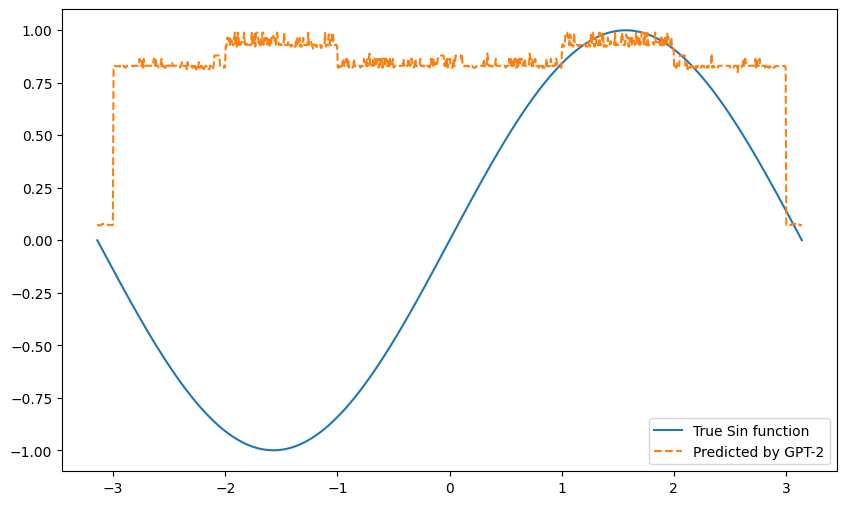

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 5. 학습 결과
model.eval()
predicted_ys = []

for xi in x:
    tokenized_input = tokenizer(f"{xi:.5f}", return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(tokenized_input.input_ids)
        predictions = outputs.logits
    predicted_token = torch.argmax(predictions, dim=2)
    predicted_text = tokenizer.decode(predicted_token[0], skip_special_tokens=True)
    
    # 텍스트를 숫자로 변환하는 함수
    try:
        predicted_ys.append(float(predicted_text))
    except ValueError:  # 숫자 변환 오류 처리
        predicted_ys.append(0)  # 잘못된 예측값은 0으로 처리 (적절한 처리 방법을 선택해야 함)

# 6. 결과 시각화
plt.figure(figsize=(10,6))
plt.plot(x, y, label='True Sin function')
plt.plot(x, predicted_ys, label='Predicted by GPT-2', linestyle='dashed')
plt.legend()
plt.show()


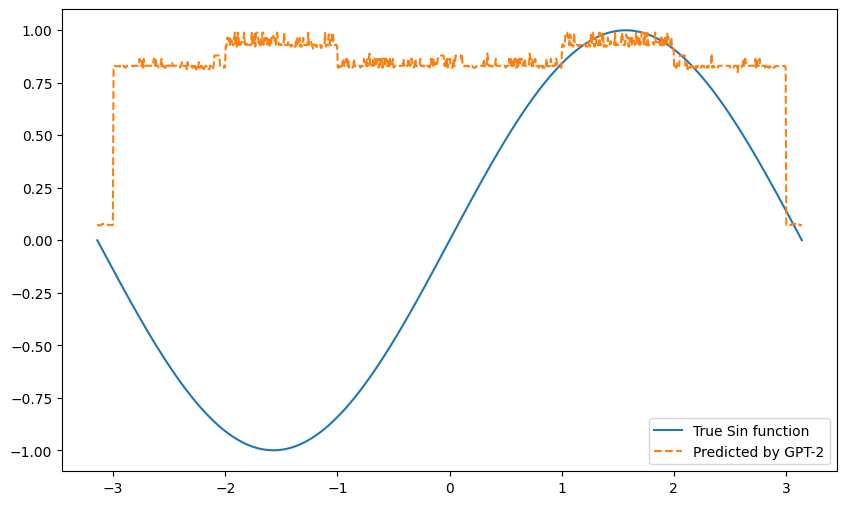

In [5]:
# Save image 
plt.figure(figsize=(10,6))
plt.plot(x, y, label='True Sin function')
plt.plot(x, predicted_ys, label='Predicted by GPT-2', linestyle='dashed')
plt.legend()
plt.savefig('gpt_sin.png')
